In [305]:
import pandas as pd
from datetime import datetime, date
import numpy as np
from sklearn import ensemble, model_selection, preprocessing
import matplotlib.pyplot as plt
import operator
import requests
import time
import os

## Import Data

In [2]:
def importData(filename):
    data = pd.read_csv(filename, sep='\t', low_memory=False)
    return data

In [3]:
data06 = importData('citations2006.tsv')
data07 = importData('citations2007.tsv')
data08 = importData('citations2008.tsv')
data09 = importData('citations2009.tsv')
data10 = importData('citations2010.tsv')
data11 = importData('citations2011.tsv')
data12 = importData('citations2012.tsv')
data13 = importData('citations2013.tsv')
data14 = importData('citations2014partial.tsv') # Partial

In [4]:
data = pd.concat([data06, data07, data08, data09,
                 data10, data11, data12, data13, data14]).reset_index()

In [5]:
len(data)

1024303

## Exploring Features

In this section, we will explore the basic features provided in the dataset.

**Description of Features:**

* Created
    * * `index`: original index of entry in datasets separated by years. Only present for ID purposes; non-substantive.

* Citation Information (information about the citation itself)
    * `CitationNumber`: ID number assigned by Philadelphia government; each citation has a unique `CitationNumber`.
    * `FiledDate`: date the citation was processed in the appropriate office.
    * `IssueDate`: date the citation was issued.  
    * `ViolationCode`: [some violation codes](http://william.e.jones.tripod.com/law/traffic_violations.htm). Haven't been able to find a full list of violation codes.
    * `ViolationTitle`: description of the violation.
    * `Location`: where the citation was issued.
    * `Agency`: the agency that issued the citation (e.g., Penn police, Drexel police, SEPTA, etc.)
    * `HearingDate`: date of hearing.
    * `HearingTime`: time of hearing.
* Defendant Information (information about the defendant)
    * `DefendantLastName`: last name of the defendant.  
    * `DefendantFirstName`: first name of the defendant.
    * `DefCity`: defendant's city of residence.
    * `DefState`: defendant's state of residence.
    * `DefZip`: defendant's zip code.
    * `DOB`: defendant's DOB.
    * `Sex`: defendant's sex.
* Outcome information (information about the outcome of the citation)
    * `AmountDue`: fines charged to defendant.
    * `AmountPaid`: fines paid by the defendant.
    * `ClosingDisposition`: judge's decision (guilty, not guilty, etc.)
    * `DispoDate`: date disposition was issued.
    * `JudgeAdmin`: name of judge presiding

Let's take a look at some basic features of the dataset:

### Dates

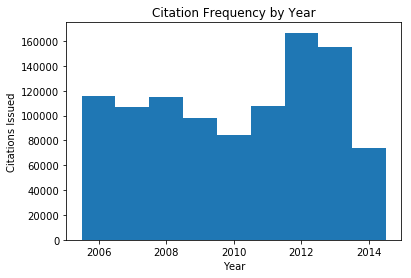

In [6]:
# Citation Dates by year

years = [int(x[-4:]) for x in data['IssueDate']]

plt.hist(years, bins=list(set(years))+[2015], align='left', color=None)
plt.xlabel("Year")
plt.ylabel("Citations Issued")
plt.title("Citation Frequency by Year")
plt.show()

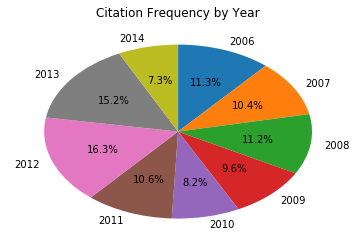

In [7]:
#...or use a pie chart:

years = [int(x[-4:]) for x in data['IssueDate']]

wedges = list(set(years))
wedge_list = []

for wedge in wedges:
    x = years.count(wedge)
    wedge_list += [x]

plt.pie(wedge_list, labels=wedges, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Citation Frequency by Year")
plt.show()

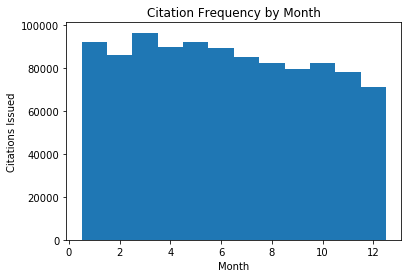

In [8]:
# Citation dates by month

months = [int(str.split(x, '/')[0]) for x in data['IssueDate']]

plt.hist(months, bins=list(set(months))+[13], align='left', color=None)
plt.xlabel("Month")
plt.ylabel("Citations Issued")
plt.title("Citation Frequency by Month")
plt.show()

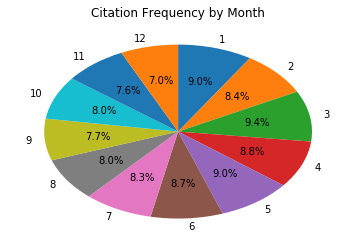

In [9]:
#...or use a pie chart:

months = [int(str.split(x, '/')[0]) for x in data['IssueDate']]

wedges = list(set(months))
wedge_list = []

for wedge in wedges:
    x = months.count(wedge)
    wedge_list += [x]

plt.pie(wedge_list, labels=wedges, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Citation Frequency by Month")
plt.show()

## Cleaning Features

In [10]:
data.columns

Index(['index', 'CitationNumber', 'FiledDate', 'IssueDate', 'ViolationCode',
       'ViolationTitle', 'Location', 'Agency', 'DefendantLastName',
       'DefendantFirstName', 'DefCity', 'DefState', 'DefZip', 'DOB', 'Sex',
       'AmountDue', 'AmountPaid', 'ClosingDisposition', 'DispoDate',
       'JudgeAdmin', 'OwnerLastName', 'OwnerFirstName', 'OwnerCity',
       'OwnerState', 'OwnerZip', 'HearingDate', 'HearingTime'],
      dtype='object')

### i. Missing Data

First, we'll deal with `NaN`s.

In [11]:
for feature in data.columns:
    num_null = len(data[data[feature].isnull() == True])
    print('{feature}: {num_null} NaNs'.format(feature=feature, num_null=num_null))

index: 0 NaNs
CitationNumber: 0 NaNs
FiledDate: 0 NaNs
IssueDate: 0 NaNs
ViolationCode: 0 NaNs
ViolationTitle: 0 NaNs
Location: 0 NaNs
Agency: 0 NaNs
DefendantLastName: 11 NaNs
DefendantFirstName: 11 NaNs
DefCity: 0 NaNs
DefState: 2 NaNs
DefZip: 0 NaNs
DOB: 0 NaNs
Sex: 0 NaNs
AmountDue: 0 NaNs
AmountPaid: 0 NaNs
ClosingDisposition: 0 NaNs
DispoDate: 0 NaNs
JudgeAdmin: 0 NaNs
OwnerLastName: 12 NaNs
OwnerFirstName: 45 NaNs
OwnerCity: 4 NaNs
OwnerState: 2 NaNs
OwnerZip: 0 NaNs
HearingDate: 0 NaNs
HearingTime: 0 NaNs


The dataset looks pretty good -- not many `NaN`s. For now, we'll just drop the missing data, since it represents such a small fraction of the dataset. 

In [12]:
data = data.dropna(axis=0, how='any')

In [13]:
len(data)

1024228

However, upon closer inspection we've realized that there are also some blank entries, e.g. `DispoDate` at index 5:

In [14]:
data.iloc[5]['DispoDate']

' '

In [15]:
for feature in data.columns:
    num_blank = len([x for x in data[feature] if str(x).isspace() == True])
    print('{feature}: {num_blank} blanks'.format(feature=feature, num_blank=num_blank))

index: 0 blanks
CitationNumber: 0 blanks
FiledDate: 0 blanks
IssueDate: 0 blanks
ViolationCode: 0 blanks
ViolationTitle: 0 blanks
Location: 9735 blanks
Agency: 0 blanks
DefendantLastName: 57 blanks
DefendantFirstName: 6847 blanks
DefCity: 157 blanks
DefState: 228 blanks
DefZip: 110 blanks
DOB: 16222 blanks
Sex: 45924 blanks
AmountDue: 418 blanks
AmountPaid: 159 blanks
ClosingDisposition: 38879 blanks
DispoDate: 38879 blanks
JudgeAdmin: 39820 blanks
OwnerLastName: 372618 blanks
OwnerFirstName: 380010 blanks
OwnerCity: 704502 blanks
OwnerState: 717245 blanks
OwnerZip: 679887 blanks
HearingDate: 6741 blanks
HearingTime: 64881 blanks


Lots of blanks. What happens if we drop them?

In [104]:
noblank_data = data[(data['Location'].str.isspace() == False) 
     & (data['DefendantLastName'].str.isspace() == False) 
     & (data['DefendantFirstName'].str.isspace() == False)
     & (data['DefCity'].str.isspace() == False) 
     & (data['DefState'].str.isspace() == False)
     & (data['DefZip'].str.isspace() == False)
     & (data['DOB'].str.isspace() == False)
     & (data['Sex'].str.isspace() == False)
     & (data['AmountDue'].str.isspace() == False)
     & (data['AmountPaid'].str.isspace() == False)
     & (data['ClosingDisposition'].str.isspace() == False)
     & (data['DispoDate'].str.isspace() == False)
     & (data['JudgeAdmin'].str.isspace() == False)
     & (data['OwnerLastName'].str.isspace() == False)
     & (data['OwnerFirstName'].str.isspace() == False)
     & (data['OwnerCity'].str.isspace() == False)
     & (data['OwnerState'].str.isspace() == False)
     & (data['DefendantLastName'].str.isspace() == False)
     & (data['OwnerZip'].str.isspace() == False)
     & (data['HearingDate'].str.isspace() == False)
     & (data['HearingTime'].str.isspace() == False)]

In [105]:
len(noblank_data)/len(data)

0.23905419496440244

Only about 24% of the data has rows with no blank entries, which is pretty low. Let's look at ways we can reconstruct or adapt these categories so that we get a bit more data.

For our preliminary model, we want to include:

VARIABLES W/ BLANKS
- Location where citation was issued
- Defendant location
- Defendant age
- Defendant sex
- Closing disposition
- Judge
- HearingDate

VARIABLES W/O BLANKS
- FiledDate
- IssueDate
- Agency
- ViolationCode



(just based on some educated guesswork about what might matter...)

So let's only look at dealing with blanks in these categories.

**1. Citation Location**

Drop rows where `Location` is blank.

In [82]:
def dropBlanks(colname, df): # Drops blanks by column
    df2 = df[df[colname].str.isspace() == False]
    return df2

In [418]:
data2 = dropBlanks('Location', data)

In [419]:
len(data2)

1014493

**2. Defendant Location**

The `DefCity` and `DefState` variables are rendered redundant by `DefZip`, so we don't care about blanks in those columns. We do, however, care about blanks in `DefZip`. For now (?), let's just drop the columns where `DefZip` is unknown, and drop `DefCity` and `DefState` completely.

In [420]:
data2 = dropBlanks('DefZip', data2)

In [421]:
len(data2)

1014384

**3. Defendant Age**

Drop columns where `DOB` is blank.

In [422]:
data2 = dropBlanks('DOB', data2)

In [423]:
len(data2)

998369

**4. Sex**

Drop columns where `Sex` is blank (but we might want to reconstruct this later from FirstName (?))

In [424]:
data2 = dropBlanks('Sex', data2)

In [425]:
len(data2)

964853

**5. Closing Disposition**

Drop columns where `ClosingDisposition` is blank.

In [426]:
data2 = dropBlanks('ClosingDisposition', data2)

In [427]:
len(data2)

929720

**5. Judge**

Drop columns where `Judge` is blank.

In [428]:
data2 = dropBlanks('JudgeAdmin', data2)

In [429]:
len(data2)

929190

**6. HearingDate**

Drop columns where HearingDate is blank.

In [430]:
data2 = dropBlanks('HearingDate', data2)

In [431]:
len(data2)

926678

Overall, we've dropped around 10% of the data:

In [432]:
len(data2)/len(data)

0.904757534455219

Now let's just get the columns that matter to us:

In [434]:
data2.columns

Index(['index', 'CitationNumber', 'FiledDate', 'IssueDate', 'ViolationCode',
       'ViolationTitle', 'Location', 'Agency', 'DefendantLastName',
       'DefendantFirstName', 'DefCity', 'DefState', 'DefZip', 'DOB', 'Sex',
       'AmountDue', 'AmountPaid', 'ClosingDisposition', 'DispoDate',
       'JudgeAdmin', 'OwnerLastName', 'OwnerFirstName', 'OwnerCity',
       'OwnerState', 'OwnerZip', 'HearingDate', 'HearingTime'],
      dtype='object')

In [439]:
data2 = data2[['FiledDate', 'IssueDate', 'ViolationCode', 'ViolationTitle', 
       'Location', 'Agency', 'DefZip', 'DOB', 'Sex',
       'ClosingDisposition', 'JudgeAdmin', 'HearingDate']]

### ii. Converting Features

Now we'll figure out how to deal with string variables.

**1. `FiledDate`, `IssueDate`, `HearingDate` ** We'll convert to four different categories: year, month, day, and day-of-week.

In [113]:
# Converting dates

def ConvertDate(date_name, data):
    
    # Get data from dataframe
    dates = list(data[date_name])
    datetimes = [datetime.strptime(x, '%m/%d/%Y') for x in dates]
    
    # Create new data
    years = [x.year for x in datetimes]
    months = [x.month for x in datetimes]
    days = [x.day for x in datetimes]
    weekdays = [x.weekday() for x in datetimes]
    
    #Add to dataframe
    data2 = data.copy()
    yearname = date_name + '_Year'
    monthname = date_name + '_Month'
    dayname = date_name + '_Day'
    weekdayname = date_name + '_Weekday'
    data2[yearname] = years
    data2[monthname] = months
    data2[dayname] = days
    data2[weekdayname] = weekdays
    
    return data2

In [116]:
modeldata = ConvertDate('FiledDate', data2)
modeldata = ConvertDate('IssueDate', modeldata)

In [117]:
modeldata = ConvertDate('HearingDate', modeldata)

modeldata.head()

**2. Location**

We will convert `Location` to latitude, longitude, and zip.

Unfortunately, the Google Maps API is rate-limited to max 2500 lookups/day, and I don't have the funds and/or time to process a million lookups! Here are 2 ways to make it faster:

1. Only lookup each individual address once.
2. I can use the [Census address lookup](https://geocoding.geo.census.gov/geocoder/locations/addressbatch?form) to get some latitudes/longitudes/zip codes, and use the Google Maps API to get the rest.

**2a. Census Address Lookup**

In [271]:
# Drop duplicate addresses

unique_locations_df = modeldata.drop_duplicates(subset='Location')[['Location']]

In [273]:
# Turning location into Census-Lookup-readable

census_addresses_df = pd.DataFrame(data={'street': list(unique_locations_df['Location']), 
                                         'city': ['Philadelphia']*len(unique_locations_df), 
                                         'state': ['PA']*len(unique_locations_df),
                                         'zip' : [19102]*len(unique_locations_df)}) # we just guess the zip code, since census lookup requires it

In [388]:
# Break up by batch of 10,000

def sliceDF(df, length, name, column_list):

    indices = list(range(0, len(df)+length, length))
    
    try:
        os.mkdir(name)
    except FileExistsError:
        os.chdir(name)

    for i in range(0, len(indices)-1):
        start = indices[i]
        end = indices[i+1]-1

        df_temp = df[start:end]
        df_temp = df_temp[column_list]

        df_temp.to_csv(name+str(i)+'.csv', header=False)
    
    os.chdir('..')
        
    return None
    

In [387]:
sliceDF(census_addresses_df, 5000, 'census_addresses_', ['street', 'city', 'state', 'zip'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


Not shown: putting all 17 files through the Census website by hand!

**2b. Google Maps API Lookup**

In [200]:
# Turn Location into Google-Maps-API-readable

new_locations = [x.replace("&", " & ")+", Philadelphia, PA" for x in list(modeldata['Location'])]
modeldata['GMaps_Location'] = new_locations

In [121]:
#gmaps_api_key = "XXX"

In [229]:
def getCoords(address, gmaps_api_key):
    
    address_string = address.replace(' ', '+')
    url = "https://maps.googleapis.com/maps/api/geocode/json?address=" + address_string + "&key=" + gmaps_api_key
    r = requests.get(url)
    
    try:
        lat = r.json()['results'][0]['geometry']['location']['lat']
        lng = r.json()['results'][0]['geometry']['location']['lng']
        zipcode = r.json()['results'][0]['address_components'][7]['long_name']
        return (lat, lng, zipcode)
    
    except IndexError:
        return (np.nan, np.nan, np.nan)

Due to some limits on the Google Maps API, we'll only be able to run 2,500 requests/day and 50 requests/min...

In [231]:
# Request max from GMaps for one day:

def requestCoords(addresses_df, gmaps_api_key):
    
    #for i in range(0, 45):
        
    locations_df = pd.DataFrame(data={'index': [], 'address': [], 'lat': [], 'lng': [], 'zipcode': []})

    for index, row in addresses_df.iterrows():
        address = row['GMaps_Location']
        print(address)

        # Get coordinates
        lat, lng, zipcode = getCoords(address, gmaps_api_key)
        locations_df_temp = pd.DataFrame(data={'index' : [index], 'address': [address], 'lat': [lat], 'lng': [lng], 'zipcode': [zipcode]})
        locations_df = pd.concat([locations_df, locations_df_temp])
        time.sleep(1.2)
        
    return locations_df

In [222]:
addresses_df = modeldata[['GMaps_Location']]

In [253]:
addresses_df.to_csv('addresses_df.csv')

**3. DOB** 

We'll turn DOB into age, for now (?).

In [308]:
dob_datetime = [datetime.strptime(x, '%m/%d/%Y') for x in modeldata['DOB']]

In [315]:
def calculateAge(dob):
    
    age = datetime.today().year - dob.year
    
    if datetime.today().month < dob.month:
        age = age-1
    
    return age

In [317]:
age = [calculateAge(x) for x in dob_datetime]

In [319]:
modeldata['Age'] = age

**4. Constructing Enums: `Agency, Sex, ClosingDisposition, JudgeAdmin`, `ViolationCode`**

`Agency`, `Sex`, `ClosingDisposition`, `JudgeAdmin`, and `ViolationCode` can all be converted into enums.

In [324]:
def addEnum(df, category_name):
    
    df2 = df.copy()
    
    enum_name = category_name + '_Enum'
    
    categories = list(df[category_name].drop_duplicates())
    enums = list(range(len(categories)))
    
    enum_dict = dict(zip(categories, enums))
    
    enum_list = [enum_dict[x] for x in df[category_name].tolist()]
    
    df2[enum_name] = enum_list
    
    return df2
    

In [477]:
def addDummyVariable(df, category_name):
    
    df2 = df.copy()
    
    categories = list(df2[category_name].drop_duplicates())
    
    for category in categories:
        newcolname = category_name + "_" + str(category)
        vec = (df2[category_name] == category)
        df2[newcolname] = vec.astype(int)
        
    return df2

In [341]:
def replaceValues(df, values):
    
    df2 = df.copy()
 
    for k, v in values.items():
        print('Replacing', v, 'with', k + '...')
        df2.replace(to_replace=v, value=k, inplace=True)
        
    return df2

**4a. Agency**

Add more information about agencies (?) like group to enums based on broader agency categorizations

In [484]:
modeldata['Agency'].drop_duplicates().sort_values().tolist()

['01 AID',
 '02 BRG POL',
 '03 PHL POL',
 '04 OTHER',
 '05 PENNDOT',
 '06 STA POL',
 '07 AIR POL',
 '08 PUC',
 '09 FUEL TX',
 '10 UNIV PA',
 '11 TEMPLE',
 '12 AMTRACK',
 '14 TRK ENF',
 '15 PH HOUS',
 '16 SEPTA',
 '17 STA TRK',
 '18 BRG TRK',
 '19 ST PARK',
 '20 DREXEL']

In [485]:
modeldata['Agency'] = [x.strip() for x in modeldata['Agency']]

/Users/lucy/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [490]:
modeldata = addDummyVariable(modeldata, 'Agency')

**4b. Sex**

In [337]:
modeldata['Sex'].drop_duplicates()

0         M
52        F
187381    A
195666    U
523723    0
932435    1
Name: Sex, dtype: object

In [492]:
modeldata = addDummyVariable(modeldata, 'Sex')

**4c. ClosingDisposition**

In [493]:
modeldata['ClosingDisposition'].drop_duplicates().sort_values().tolist()

['APPEAL DENIED',
 'APPEAL FAIL TO APPR',
 'APPEAL GLTY W/AMEND',
 'APPEAL GLTY W/REDUCT',
 'APPEAL GUILTY IPP',
 'APPEAL SUSTAINED',
 'APPEAL WITHDRAWN',
 'COMMIT TRIAL SCHD',
 'DECEASED',
 'DISMISS IDENTY FRAUD',
 'DISMISSAL',
 'GLTY IN ABSN/R453/SO',
 'GLTY IN ABSNTIA R453',
 'GUILTY',
 'GUILTY CHANGE PLEA',
 'GUILTY IN ABSENTIA',
 'GUILTY IPP',
 'GUILTY PLEA',
 'GUILTY RULE 453',
 'GUILTY W/AMENDMENT',
 'GUILTY W/REDUCTION',
 'NOT GLTY IN ABSENTIA',
 'NOT GLTY STAT OF LIM',
 'NOT GUILTY',
 'NOT GUILTY DECEASED',
 'NUNC APL HEAR DENIED',
 'NUNC APL HEAR GRNTED',
 'PLEA BARGAIN',
 'PLED GUILTY AT TRIAL',
 'PROSECUT W/DRAWN 147',
 'PROSECUTION W/DRAWN',
 'TIME SERVED FULL RED',
 'VOID TICKET']

In [494]:
modeldata['ClosingDispostion'] = [x.rstrip() for x in modeldata['ClosingDisposition']]

We might think that some `ClosingDisposition`s might be the same (e.g. `GLTY IN ABSN/R453/SO` and `GLTY IN ABSNTIA R453`) but we'll think about that later.

In [495]:
modeldata = addDummyVariable(modeldata, 'ClosingDisposition')

We also probably want a simple guilty/not guilty classification. We will begin by determining which categories are guilty and which are not guilty:

GUILTY  
- `APPEAL DENIED`
- `APPEAL FAIL TO APPR`
- `APPEAL GLTY W/AMEND`
- `APPEAL GLTY W/REDUCT`
- `APPEAL GUILTY IPP`
- `APPEAL WITHDRAWN`
- `GLTY IN ABSN/R453/SO`
- `GLTY IN ABSNTIA R453`
- `GUILTY`
- `GUILTY CHANGE PLEA`
- `GUILTY IN ABSENTIA`
- `GUILTY IPP`
- `GUILTY PLEA`
- `GUILTY RULE 453`
- `GUILTY W/ AMENDMENT`
- `GUILTY W/ REDUCTION`
- `PLED GUILTY AT TRIAL`


NOT GUILTY
- `APPEAL SUSTAINED`
- `DISMISSAL`
- `NOT GLTY IN ABSENTIA`
- `NOT GLTY STAT OF LIM`
- `NOT GUILTY`
- `NOT GUILTY DECEASED`
- `PROSECUT W/DRAWN 147`
- `PROSECUTION W/DRAWN`
- `DISMISS IDENTITY FRAUD`

NEITHER
- `COMMIT TRIAL SCHD` (can't figure out what this one means)
- `DECEASED`
- `NUNC APPEAL HEAR DENIED`
- `NUNC APPEAL HEAR GRNTED`
- `PLEA BARGAIN`
- `TIME SERVED FULL RED`
- `VOID TICKET`

In [516]:
vec = modeldata[['ClosingDisposition_NOT GUILTY', 
       'ClosingDisposition_NOT GLTY STAT OF LIM',
       'ClosingDisposition_APPEAL SUSTAINED', 
       'ClosingDisposition_NOT GLTY IN ABSENTIA',
       'ClosingDisposition_PROSECUTION W/DRAWN',
       'ClosingDisposition_PROSECUT W/DRAWN 147',
       'ClosingDisposition_DISMISS IDENTY FRAUD',
       'ClosingDisposition_DISMISSAL',
       'ClosingDisposition_NOT GUILTY DECEASED']].sum(axis=1)

vec2 = (vec >= 1)

modeldata['ClosingDisposition_NotGuiltyTotal'] = vec2.astype(int)

In [539]:
vec = modeldata[['ClosingDisposition_GUILTY IN ABSENTIA',
                 'ClosingDisposition_GLTY IN ABSNTIA R453',
                 'ClosingDisposition_GUILTY PLEA',
                 'ClosingDisposition_GUILTY IPP',
                 'ClosingDisposition_APPEAL GLTY W/AMEND',
                 'ClosingDisposition_GUILTY',
                 'ClosingDisposition_APPEAL FAIL TO APPR',
                 'ClosingDisposition_APPEAL DENIED',
                 'ClosingDisposition_GUILTY RULE 453',
                 'ClosingDisposition_GUILTY W/AMENDMENT',
                 'ClosingDisposition_APPEAL WITHDRAWN',
                 'ClosingDisposition_GUILTY W/REDUCTION',
                 'ClosingDisposition_GUILTY CHANGE PLEA',
                 'ClosingDisposition_APPEAL GLTY W/REDUCT',
                 'ClosingDisposition_GLTY IN ABSN/R453/SO',
                 'ClosingDisposition_PLED GUILTY AT TRIAL',
                 'ClosingDisposition_APPEAL GUILTY IPP']].sum(axis=1)
vec2 = (vec >= 1)

modeldata['ClosingDisposition_GuiltyTotal'] = vec2

In [550]:
vec = modeldata[['ClosingDisposition_COMMIT TRIAL SCHD', 
                 'ClosingDisposition_DECEASED', 
                'ClosingDisposition_NUNC APL HEAR DENIED',
                'ClosingDisposition_NUNC APL HEAR GRNTED',
                'ClosingDisposition_PLEA BARGAIN',
                'ClosingDisposition_TIME SERVED FULL RED',
                'ClosingDisposition_VOID TICKET']].sum(axis=1)

vec2 = (vec >= 1)

modeldata['ClosingDisposition_NeitherTotal'] = vec2

In [542]:
modeldata['ClosingDisposition_GuiltyTotal'].sum()

580733

In [543]:
modeldata['ClosingDisposition_NotGuiltyTotal'].sum()

320841

In [551]:
modeldata['ClosingDisposition_NeitherTotal'].sum()

25104

In [553]:
580733+320841+25104 == len(modeldata)

True

**4d. Judge**

In [361]:
modeldata['JudgeAdmin'].drop_duplicates().sort_values().tolist()

['ADM',
 'ADM              ',
 'ADMINISTRATIVE',
 'ADMINISTRATIVE   ',
 'APL',
 'APL              ',
 'APPEAL',
 'APPEAL           ',
 'APPEAL - TIMELY',
 'APPEAL - TIMELY  ',
 'APPEAL - UNTIMELY',
 'APPEAL NUNC PRO T',
 'BERNICE DEANGELIS',
 'BHARATI PATEL',
 'BHARATI PATEL    ',
 'CHRISTINE SOLOMON',
 'COURT A',
 'COURT A          ',
 'COURT B',
 'COURT B          ',
 'COURT C',
 'COURT C          ',
 'COURT D',
 'COURT E',
 'COURT F',
 'COURTROOM X',
 'COURTROOM X      ',
 'DA COURT',
 'DEMETRIOS SEMOS',
 'DEMETRIOS SEMOS  ',
 'DERRICK COKER',
 'DERRICK COKER    ',
 'DOMENIC REDA',
 'EARLENE GREEN',
 'EDWARD COX',
 'F. ELAINE BERKOFF',
 'FD - FINANCIAL DE',
 'FORTUNATO PERRI',
 'GARY GLAZER',
 'GEORGE TWARDY',
 'GLORIA INLANDER',
 'HORACE DAVIS',
 'IMPOUND',
 'IMPOUND          ',
 'JOANN TEYRAL',
 'JOHN S MURRAY',
 'JOHN S MURRAY    ',
 'JOSEPH QUINN',
 'KENNETH MILLER',
 'LARRY SMITH',
 'LARRY SMITH      ',
 'LOCKBOX',
 'LOCKBOX          ',
 'MICHAEL LOWRY',
 'MICHAEL SULLIVAN',
 '

In [396]:
modeldata['ClosingDisposition'] = [x.strip() for x in modeldata['ClosingDisposition']]

In [397]:
replace_dict = {'APPEAL': 'APL',
               'SYSTEM': 'SYS'}

modeldata = replaceValues(modeldata, replace_dict)

Replacing APL with APPEAL...
Replacing SYS with SYSTEM...


In [554]:
modeldata = addDummyVariable(modeldata, 'JudgeAdmin')

**4e. ViolationCode**

In [389]:
modeldata['ViolationCode'].drop_duplicates().sort_values().tolist()

['1.10E+05',
 '1.10E+06',
 '1.79E+04',
 '1.79E+05',
 '1.79E+06',
 '1.79E+08',
 '104005',
 '1101',
 '1101A',
 '1101A     ',
 '1103',
 '11031A',
 '11031B',
 '11031D',
 '11031D    ',
 '1111',
 '1111A',
 '1111B',
 '1113A',
 '1113B',
 '1114A',
 '1115A',
 '1119A',
 '1119A1',
 '1119B',
 '1119B     ',
 '1119C',
 '1119C1    ',
 '1211061',
 '121126',
 '121128',
 '121601',
 '1216011',
 '1216012',
 '1216021',
 '121603',
 '121604',
 '1216051',
 '1216061',
 '122603',
 '12404',
 '126011',
 '12808',
 '12812',
 '129011D',
 '129021B',
 '1301',
 '1301A',
 '1301A     ',
 '1301B',
 '1301C',
 '1301C     ',
 '1301D',
 '1301D     ',
 '1301D2',
 '1302',
 '13029',
 '1303',
 '1303A',
 '1303A     ',
 '1303B',
 '1304',
 '1304A',
 '1304B',
 '1304D',
 '1304E',
 '1304E     ',
 '1305',
 '1305A',
 '1305B',
 '1307',
 '1309',
 '1310',
 '13101C',
 '1310A',
 '1310C',
 '1311',
 '1311A',
 '1311A     ',
 '1311B',
 '1311B     ',
 '1311C',
 '1312',
 '1313B',
 '1314',
 '1315',
 '1318',
 '1331',
 '1331B',
 '1331C',
 '1332',
 '133

In [403]:
modeldata['ViolationCode'] = [x.strip() for x in modeldata['ViolationCode']]

In [412]:
modeldata['ViolationTitle'] = [x.rstrip() for x in modeldata['ViolationTitle']]

In [462]:
len(modeldata['ViolationCode'].drop_duplicates())

713

Creating an Enum for these `ViolationCode`s is going to be a bit more involved. Since there are over 700 distinct violation codes, it doesn't really make sense to create a separate category for each code. Instead, we will create broader groups that encompass multiple violation codes.

Based on the site [linked](http://william.e.jones.tripod.com/law/traffic_violations.htm) earlier and some inspection of the data, we will create the following groupings:

| Violation Code             | Description                                                                         |
|----------------------------|-------------------------------------------------------------------------------------|
| 1000s, 2100s, 7000s, 9000s | *Paperwork*: Paperwork issue (expired registration, obscured plates, etc.)                       |
| 3000s                      | *Driving*: Violation of driving laws (running red light, speeding, etc.)                       |
| 4000s                      | *Safety*: Failure to use proper safety measures (no seatbelt, improper child restraint, etc.) |
| 6000s                      | *Police*: Police-related rule violations (failure to comply with investigation, etc.)         |
| 8000s                      | *Hazard*: Hazardous materials violations                                                      |
| 12-XXXX                    | *Philly*: Violation of Philadelphia-specific traffic laws                                     |


In [574]:
modeldata[modeldata['ViolationCode'].str.startswith('3')]

,FiledDate,IssueDate,ViolationCode,ViolationTitle,Location,Agency,DefZip,DOB,Sex,ClosingDisposition,...,JudgeAdmin_JOANN TEYRAL,JudgeAdmin_STEPHANIE KLEIN,JudgeAdmin_YOUNG SONG,JudgeAdmin_DERRICK COKER,JudgeAdmin_BHARATI PATEL,JudgeAdmin_FD - FINANCIAL DE,JudgeAdmin_GARY GLAZER,JudgeAdmin_GEORGE TWARDY,ViolationCode_Safety,ViolationCode_Paperwork
6,1/24/2006,1/20/2006,3331A,IMPROPER TURN RIGHT,15TH&JFK BLVD,03 PHL POL,19121,2/18/1966,M,NOT GUILTY,...,0,0,0,0,0,0,0,0,0,0
7,1/31/2006,1/26/2006,3304B,PASS RIGHT UNSAFE,2500 PENNA AVE,03 PHL POL,19121,2/18/1966,M,NOT GUILTY,...,0,0,0,0,0,0,0,0,0,0
12,6/23/2006,6/19/2006,3112A31,DISREGRD RED IND,RIDGE&ROXBOROUGH AVE,03 PHL POL,19701,5/15/1954,M,NOT GUILTY,...,0,0,0,0,0,0,0,0,0,0
18,5/5/2006,5/3/2006,3362A1,EXCEED 35MPH URBAN,NB KELLY&BREWERY HIL,03 PHL POL,2446,7/10/1954,M,GUILTY IN ABSENTIA,...,0,0,0,0,0,0,0,0,0,0
21,10/11/2006,10/7/2006,3362A2,EXCEED 55MPH OTHER,I95 SB AT AIRPORT,03 PHL POL,19013,11/3/1954,M,GUILTY IN ABSENTIA,...,0,0,0,0,0,0,0,0,0,0
34,2/6/2006,2/1/2006,3112A31,DISREGRD RED IND,CHEW&WALNUT LN,03 PHL POL,19144,3/25/1971,M,NOT GUILTY,...,0,0,0,0,0,0,0,0,0,0
37,9/15/2006,9/6/2006,3303A1,PASS IMPR ON LEFT,6700 WOODLAND,03 PHL POL,8094,8/26/1960,M,GUILTY IN ABSENTIA,...,0,0,0,0,0,0,0,0,0,0
38,10/5/2006,9/29/2006,3303A1,PASS IMPR ON LEFT,63RD WOODLAND AVE,03 PHL POL,8094,8/26/1960,M,GUILTY IN ABSENTIA,...,0,0,0,0,0,0,0,0,0,0
40,6/27/2006,6/20/2006,3323B,DISRGRD STOP SIGN,1000 N 3RD ST,03 PHL POL,8081,9/5/1946,M,GLTY IN ABSNTIA R453,...,0,0,0,0,0,0,0,0,0,0
41,6/27/2006,6/20/2006,3714,CARELESS DRIVING,1000 N 3RD ST,03 PHL POL,8081,9/5/1946,M,GLTY IN ABSNTIA R453,...,0,0,0,0,0,0,0,0,0,0


In [573]:
vec1 = (~modeldata['ViolationCode'].str.startswith('12') & modeldata['ViolationCode'].str.startswith('1')).astype(int)
vec2 = modeldata['ViolationCode'].str.startswith('21').astype(int)
vec3 = modeldata['ViolationCode'].str.startswith('7').astype(int)
vec4 = modeldata['ViolationCode'].str.startswith('9').astype(int)

vec = vec1 + vec2 + vec3 + vec4

vecf = (vec >= 1)
modeldata['ViolationCode_Paperwork'] = vecf.astype(int)

In [577]:
vec = modeldata['ViolationCode'].str.startswith('3')
modeldata['ViolationCode_Driving'] = vec.astype(int)

In [576]:
vec = modeldata['ViolationCode'].str.startswith('4')
modeldata['ViolationCode_Safety'] = vec.astype(int)

In [578]:
vec = modeldata['ViolationCode'].str.startswith('6')
modeldata['ViolationCode_Police'] = vec.astype(int)

In [579]:
vec = modeldata['ViolationCode'].str.startswith('8')
modeldata['ViolationCode_Hazard'] = vec.astype(int)

In [580]:
vec = modeldata['ViolationCode'].str.startswith('12')
modeldata['ViolationCode_Philly'] = vec.astype(int)

In [585]:
modeldata[['ViolationCode_Paperwork', 
           'ViolationCode_Driving', 
           'ViolationCode_Safety', 
           'ViolationCode_Police', 
           'ViolationCode_Hazard', 
           'ViolationCode_Philly']].values.sum()

926678

In [586]:
len(modeldata)

926678

In [587]:
modeldata.to_csv('modeldata.csv')

### Initial Model

In [ ]:
m1df = modeldata[['ViolationCode', 'ViolationTitle', 'Location',
       'Agency', 'DefZip', 'DOB', 'Sex', 'ClosingDisposition', 'JudgeAdmin',
       'HearingDate', 'FiledDate_Year', 'FiledDate_Month', 'FiledDate_Day',
       'FiledDate_Weekday', 'IssueDate_Year', 'IssueDate_Month',
       'IssueDate_Day', 'IssueDate_Weekday', 'HearingDate_Year',
       'HearingDate_Month', 'HearingDate_Day', 'HearingDate_Weekday',
       'GMaps_Location', 'Age', 'Agency_Enum', 'Sex_Enum',
       'ClosingDisposition_Enum']]

In [30]:
m1df = data4[['ClosingDisposition_Enum', 'ViolationCode_Enum',
             'ViolationTitle_Enum', 'Agency_Enum', 'Sex_Enum',
             'JudgeAdmin_Enum', 'FiledDate_Ordinal', 'IssueDate_Ordinal',
             'HearingDate_Ordinal']]

In [31]:
y_m1df = m1df['ClosingDisposition_Enum']

In [32]:
X_m1df = m1df[['ViolationCode_Enum',
             'ViolationTitle_Enum', 'Agency_Enum', 'Sex_Enum',
             'JudgeAdmin_Enum', 'FiledDate_Ordinal', 'IssueDate_Ordinal',
             'HearingDate_Ordinal']]

In [33]:
X_tr, X_ts, y_tr, y_ts = model_selection.train_test_split(X_m1df, y_m1df, test_size=0.20, random_state=33)

In [34]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_tr, y_tr)
print('RFC score:', rfc.score(X_ts, y_ts))

RFC score: 0.571049515264


To put this score in perspective, we can create a "baseline" model: always guessing the most common closing disposition. In this case...

In [35]:
m1df['ClosingDisposition_Enum'].value_counts().sort_values(ascending=False)

0     241802
2     191900
3     168481
7     128737
6      79460
1      35684
10     35034
29     21606
22     19787
5      18272
8      13614
9      12058
12     10470
11      9949
4       4838
14      4402
21      3499
16      3013
15      2555
20      2086
17      1749
27      1682
23      1559
32      1288
24      1272
18       880
19       856
13       765
26       236
31        13
25        11
28         2
30         1
33         1
Name: ClosingDisposition_Enum, dtype: int64

In [36]:
print("Baseline score:", 241802/len(m1df))

Baseline score: 0.23762876365273075


Compared to this baseline score of `0.2376`, our random forests classifier is performing reasonably well (`0.5722`). Let's look at the feature weights.

In [45]:
def getFeatureWeights(features, weights): #Gets feature weights for RFC
    feature_weights_dict = dict(zip(features, weights))
    sorted_feature_weights_dict = sorted(feature_weights_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    print("Feature Weights:")
    
    return sorted_feature_weights_dict

In [ ]:
getFeatureWeights(list(X_tr.columns), list(rfc.feature_importances_))

With standard scaling:

In [196]:
rfc_ss = ensemble.RandomForestClassifier()
rfc_ss.fit(X_tr_ss, y_tr)
print('rfc_ss score:', rfc_ss.score(X_ts_ss, y_ts))

rfc_ss score: 0.572056821923
Feature importances: [ 0.07503941  0.07026839  0.01206139  0.01924478  0.21944553  0.19638459
  0.18325193  0.22430398]


In [ ]:
getFeatureWeights(list(X_tr.columns), list(rfc_ss.feature_importances_))

Is date redundant?

In [39]:
dates = X_m1df[['FiledDate_Ordinal', 'IssueDate_Ordinal', 'HearingDate_Ordinal']]

In [40]:
np.corrcoef(dates, rowvar=False)

array([[ 1.        ,  0.99987709,  0.77971149],
       [ 0.99987709,  1.        ,  0.77958949],
       [ 0.77971149,  0.77958949,  1.        ]])

`FiledDate` and `IssueDate` are virtually completely correlated, so we'll remove one as a feature.

In [41]:
m2df = data4[['ClosingDisposition_Enum', 'ViolationCode_Enum',
             'ViolationTitle_Enum', 'Agency_Enum', 'Sex_Enum',
             'JudgeAdmin_Enum', 'FiledDate_Ordinal',
             'HearingDate_Ordinal']]

X_m2df = m2df[['ViolationCode_Enum',
             'ViolationTitle_Enum', 'Agency_Enum', 'Sex_Enum',
             'JudgeAdmin_Enum', 'FiledDate_Ordinal',
             'HearingDate_Ordinal']]
y_m2df = m2df['ClosingDisposition_Enum']

In [42]:
X_tr, X_ts, y_tr, y_ts = model_selection.train_test_split(X_m2df, y_m2df, test_size=0.20, random_state=33)

In [43]:
rfc3 = ensemble.RandomForestClassifier()
rfc3.fit(X_tr, y_tr)
print('RFC score:', rfc3.score(X_ts, y_ts))

RFC score: 0.56837155366


In [49]:
getFeatureWeights(list(X_tr.columns), list(rfc3.feature_importances_))

Feature Weights:


[('HearingDate_Ordinal', 0.30532733272162565),
 ('FiledDate_Ordinal', 0.29064740801733396),
 ('JudgeAdmin_Enum', 0.23465278767389766),
 ('ViolationCode_Enum', 0.071611823832139529),
 ('ViolationTitle_Enum', 0.068053848663122612),
 ('Sex_Enum', 0.017697196580768425),
 ('Agency_Enum', 0.012009602511112084)]

In [50]:
# Add day of week enum

m3df = data4[['ClosingDisposition_Enum', 'ViolationCode_Enum',
             'ViolationTitle_Enum', 'Agency_Enum', 'Sex_Enum',
             'JudgeAdmin_Enum', 'FiledDate_Ordinal',
             'HearingDate_Ordinal']]

In [53]:
m3df['HearingDate_Day'] = [datetime.fromordinal(x).weekday() for x in m3df['HearingDate_Ordinal']]

/Users/lucy/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [56]:
X_m3df = m3df[['ViolationCode_Enum',
             'ViolationTitle_Enum', 'Agency_Enum', 'Sex_Enum',
             'JudgeAdmin_Enum', 'FiledDate_Ordinal',
             'HearingDate_Ordinal', 'HearingDate_Day']]
y_m3df = m3df['ClosingDisposition_Enum']

In [57]:
X_tr, X_ts, y_tr, y_ts = model_selection.train_test_split(X_m3df, y_m3df, test_size=0.20, random_state=33)

In [58]:
rfc3 = ensemble.RandomForestClassifier()
rfc3.fit(X_tr, y_tr)
rfc3.score(X_ts, y_ts)

0.57196346179359547

In [ ]:
# Feature ideas: Add day of week 

In [54]:
m3df['HearingDate_Day']

0          1
1          1
2          2
3          2
4          2
5          1
6          2
7          2
8          4
9          4
10         4
11         4
12         0
13         4
14         4
15         0
16         0
17         0
18         0
19         2
20         2
21         0
22         0
23         2
24         2
25         2
26         3
27         3
28         3
29         3
          ..
1024273    1
1024274    1
1024275    1
1024276    1
1024277    1
1024278    1
1024279    0
1024280    0
1024281    0
1024282    1
1024283    0
1024284    1
1024285    1
1024286    1
1024287    1
1024288    1
1024289    1
1024290    1
1024291    1
1024292    1
1024293    1
1024294    1
1024295    1
1024296    0
1024297    2
1024298    2
1024299    2
1024300    1
1024301    2
1024302    1
Name: HearingDate_Day, Length: 1017562, dtype: int64